In [2]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/Volumes/KT-TOSHIBA/ENOI/CODE')
import regression_fcts as rf
import cartopy.crs as ccrs
import enoi_functions as enoi

In [3]:
newcmp = enoi.n_cmap()

In [4]:
def RMSE(var1, var2, ax):
    rmse = np.sqrt(np.nanmean((var1-var2)**2,axis=ax))
    return rmse

def detrend_ens(input_ts, idx_t, tlength):
    tot_tlength = np.size(input_ts, idx_t)
    output_ts = np.ones(np.shape(input_ts))*np.nan
    if idx_t == 0:
        for i in np.arange(int(tot_tlength/tlength)):
            sample = input_ts[i*tlength:(i+1)*tlength, :,:]
            output_ts[i*tlength:(i+1)*tlength, :,:] = scipy.signal.detrend(sample, idx_t)
    return output_ts

In [5]:
mdata = '/Volumes/KT-TOSHIBA/ENOI/sorted_model_data/'

dissic_SORTED = np.load(f'{mdata}dic_100.npy')
thetao_SORTED = np.load(f'{mdata}thetao_100.npy')
so_SORTED = np.load(f'{mdata}so_100.npy')

dissic_drift = np.load(f"drift_ts_dissic0100.npy")
thetao_drift = np.load(f"drift_ts_thetao0100.npy")
so_drift = np.load(f"drift_ts_so0100.npy")

argo_coverage= xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CODE/argo_mask.nc')
argo_mask = argo_coverage.argo_annualcoverage

years_used = -60
limit_z = 100
m0 = xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CMIP6/forcings/mol1.nc', decode_times=False)
pco2 = m0.mole_fraction_of_carbon_dioxide_in_air[years_used:,0]
pco2_extended = np.tile(pco2.data - np.nanmean(pco2.data), 
                        int(np.shape(so_SORTED)[0]/np.abs(years_used)))

lon = np.arange(0.5,360.5)
lat = np.arange(-89.5,90.5)

mdict = {'lat':'lat', 'lon':'lon', 'lev':'lev', 'lev_bnds':'lev_bnds'}

ens_dic =  xr.DataArray(data=dissic_SORTED - dissic_drift)
ens_theta =  xr.DataArray(data=thetao_SORTED - thetao_drift)
ens_sal = xr.DataArray(data=so_SORTED - so_drift)

ens_mask = np.load(f'{mdata}mask_{limit_z}.npy')
_, l_100 = enoi.create_mask(dissic_SORTED, f'{mdata}mask_100.npy')

/Volumes/KT-TOSHIBA/ENOI/CODE/enoi_functions.py:94: RuntimeWarning: invalid value encountered in divide
  test1 = np.isnan(np.mean(input_file/input_file, axis=0)) # find where model ensemble doesnt always have data


In [8]:
dic_resid = ens_dic - ens_dic.mean(axis=0)
theta_resid = ens_theta - ens_theta.mean(axis=0)
so_resid = ens_sal - ens_sal.mean(axis=0)

In [12]:
radii = 5

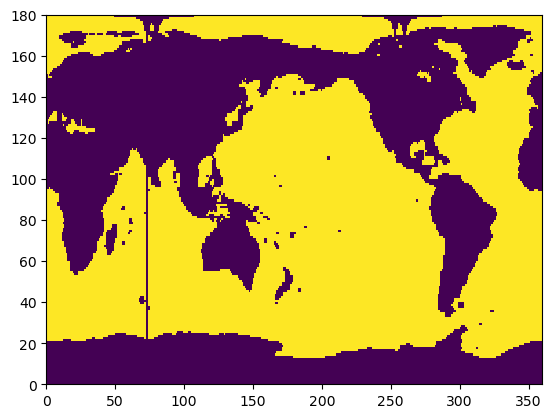

In [32]:
ens_mask = np.load(f'{mdata}mask_{limit_z}.npy')
argo_2015_mask = np.ma.masked_where((ens_mask == 0) | (argo_mask[-1,:,:]==0), argo_mask[-1,:,:])

In [28]:
full = np.arange(30*60)
rmse_argo = np.ones((6,180,360)) * np.nan
rmse_orig = np.ones((6,180,360)) * np.nan
rmse_argo_dt = np.ones((6,180,360)) * np.nan
rmse_orig_dt = np.ones((6,180,360)) * np.nan

In [ ]:
for i in np.arange(0,6):

    ri_i = np.arange(i*5*60,(i+1)*5*60)
    ri_ens = np.delete(full,ri_i)
    rmse_orig[i,:,:] = RMSE(dic_resid[ri_i,:,:],0,0)
    rmse_orig_dt[i,:,:] = RMSE(detrend_ens(dic_resid[ri_i,:,:],0,60),0,0)


    for la in np.arange(0+radii,180-1-radii):
        for lo in np.arange(0+radii,360-1-radii):
        
            if ens_mask[la,lo]==1: #check that we have DIC at the location in the first place
                loc_lat = np.arange(la-radii,la+radii+1)
                loc_lon = np.arange(lo-radii,lo+radii+1)
                dic_BATS = dic_resid[ri_ens,la,lo]

                if argo_2015_mask[loc_lat[0]:loc_lat[-1]+1, loc_lon[0]:loc_lon[-1]+1].sum() >=1: #check that we actually have ARGO profiles

                    coef_temp = np.zeros((2*radii+1,2*radii+1))
                    coef_sal = np.zeros((2*radii+1,2*radii+1))

                    sample_indices = np.where(argo_2015_mask[loc_lat[0]:loc_lat[-1]+1, loc_lon[0]:loc_lon[-1]+1]==1)
        
                    theta_subsamp = np.zeros((1500, np.shape(sample_indices)[1]))
                    sal_subsamp = np.zeros((1500, np.shape(sample_indices)[1]))
        
                    for j in np.arange(np.shape(sample_indices)[1]):
                        theta_subsamp[:,j] = theta_resid[ri_ens,loc_lat[sample_indices[0][j]], loc_lon[sample_indices[1][j]]].data
                        sal_subsamp[:,j] = ens_sal[ri_ens,loc_lat[sample_indices[0][j]], loc_lon[sample_indices[1][j]]].data
        
                    input_vars = np.concatenate((theta_subsamp,sal_subsamp,np.expand_dims(pco2_extended[ri_ens],1)),axis=1)
        
                    dummy = scipy.linalg.lstsq(input_vars, dic_BATS)
                    output_var_theta = dummy[0][0:np.shape(sample_indices)[1]]
                    output_var_sal = dummy[0][np.shape(sample_indices)[1]:-1]
                    output_var_pco2 = dummy[0][-1]
        
                    for j in np.arange(np.shape(sample_indices)[1]):
                        coef_temp[sample_indices[0][j],sample_indices[1][j]] = output_var_theta[j]
                        coef_sal[sample_indices[0][j],sample_indices[1][j]] = output_var_sal[j]
                    coef_pco2 = output_var_pco2

                    T_test = theta_resid[ri_i,loc_lat, loc_lon]
                    S_test = ens_sal[ri_i,loc_lat, loc_lon]
                    DIC_truth = dic_resid[ri_i,la,lo]
                    DIC_truth_detrend = detrend_ens(np.expand_dims(DIC_truth, (1,2)), 0, 60)[:,0,0]
                
                    test_argo = np.sum(coef_temp * T_test, axis=(1,2)) + np.sum(coef_sal * S_test, axis=(1,2)) + coef_pco2 * pco2_extended[ri_i]
                    test_argo_detrend = detrend_ens(np.expand_dims(test_argo, (1,2)), 0, 60)[:,0,0] 
                    
                    rmse_argo[i,la,lo] = np.sqrt(np.nanmean((test_argo - DIC_truth.data)**2))
                    rmse_argo_dt[i,la,lo] = RMSE(DIC_truth_detrend, test_argo_detrend,0)
        if np.mod(la,18)==0:
            print(str(i) + ' ' + str(la/90))

In [36]:
error_improv_ens0 = (-rmse_argo + rmse_orig) / rmse_orig    
error_improv_ensd0 = (-rmse_argo_dt + rmse_orig_dt) / rmse_orig_dt

/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_5463/2009738360.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


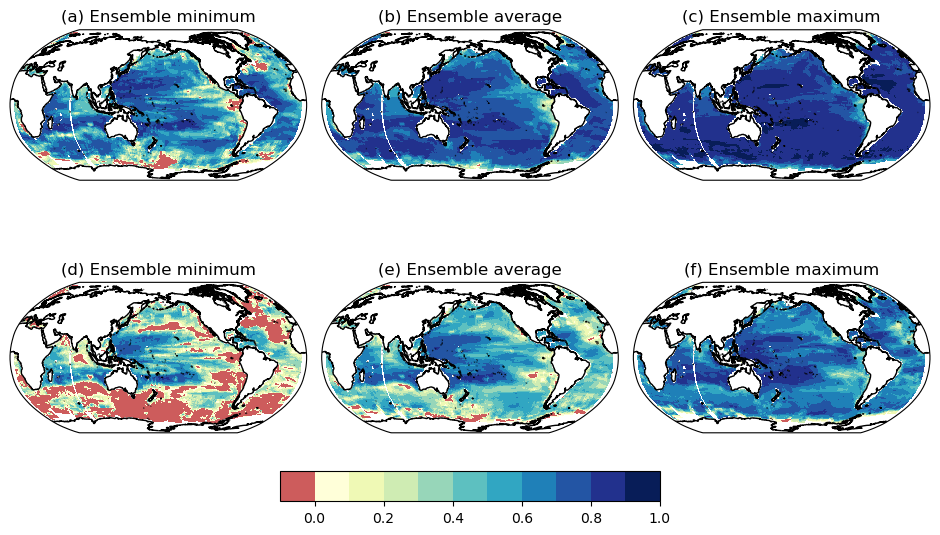

In [48]:
fig = plt.figure(figsize=(9.5, 6))
ax0 = plt.subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(a) Ensemble minimum')
ax0.coastlines('50m')
im0 = ax0.pcolormesh(lon, lat, np.ma.masked_where((ens_mask == 0), np.min(error_improv_ens0, axis = 0)), 
                     vmin=-.1, vmax=1,
                       transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                       cmap=newcmp)

ax1 = plt.subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(b) Ensemble average')
ax1.coastlines('50m')
ax1.pcolormesh(lon, lat, np.ma.masked_where((ens_mask == 0), np.mean(error_improv_ens0, axis = 0)), 
               vmin=-.1, vmax=1, 
             transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
             cmap=newcmp)

ax2 = plt.subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(c) Ensemble maximum')
ax2.coastlines('50m')
ax2.pcolormesh(lon, lat, np.ma.masked_where((ens_mask == 0), np.max(error_improv_ens0, axis = 0)), 
               vmin=-.1, vmax=1, 
             transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
             cmap=newcmp)

ax3 = plt.subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(d) Ensemble minimum')
ax3.coastlines('50m')
ax3.pcolormesh(lon, lat, np.ma.masked_where((ens_mask == 0), np.min(error_improv_ensd0, axis = 0)), 
               vmin=-.1, vmax=1,
                   transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                   cmap=newcmp)

ax4 = plt.subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(e) Ensemble average')
ax4.coastlines('50m')
ax4.pcolormesh(lon, lat, np.ma.masked_where((ens_mask == 0), np.mean(error_improv_ensd0, axis = 0)),
               vmin=-.1,vmax=1,
             transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
             cmap=newcmp)

ax5 = plt.subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(f) Ensemble maximum')
ax5.coastlines('50m')
im = ax5.pcolormesh(lon, lat, np.ma.masked_where((ens_mask == 0), np.max(error_improv_ensd0, axis = 0)), 
                    vmin=-.1, vmax=1,
             transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
             cmap=newcmp)

ax_cbar1 = fig.add_axes([0.3, 0.05, .4, 0.05])
fig.colorbar(im, cax=ax_cbar1, orientation="horizontal", pad=0.2)
plt.tight_layout()
plt.savefig('/Users/keturner/Desktop/improv_argo_t100.png', format='png', dpi=150)